In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_iris

In [3]:
iris = load_iris()

X = iris.data[:, 2:]
y = iris.target

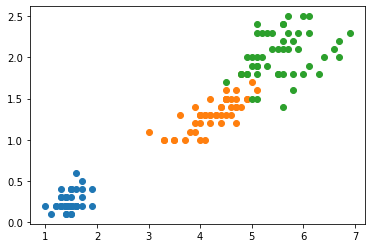

In [4]:
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])
plt.scatter(X[y==2, 0], X[y==2, 1])

In [5]:
from sklearn.tree import DecisionTreeClassifier

In [6]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=2).fit(X, y)

In [7]:
def plot_decision_boundary(model, axis):
    # meshgrid函数用两个坐标轴上的点在平面上画格，返回坐标矩阵
    X0, X1 = np.meshgrid(
        # 随机两组数，起始值和密度由坐标轴的起始值决定
        np.linspace(axis[0], axis[1], int((axis[1] - axis[0]) * 100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3] - axis[2]) * 100)).reshape(-1, 1),
    )
    # ravel()方法将高维数组降为一维数组，c_[]将两个数组以列的形式拼接起来，形成矩阵
    X_grid_matrix = np.c_[X0.ravel(), X1.ravel()]
    # 通过训练好的逻辑回归模型，预测平面上这些点的分类
    y_predict = model.predict(X_grid_matrix)
    y_predict_matrix = y_predict.reshape(X0.shape)
    
    # 设置色彩表
    from matplotlib.colors import ListedColormap
    my_colormap = ListedColormap(['#EF9A9A', '#FFF59D', '#90CAF9'])
    
    # 绘制等高线，并且填充等高区域的颜色
    plt.contourf(X0, X1, y_predict_matrix, cmap=my_colormap)

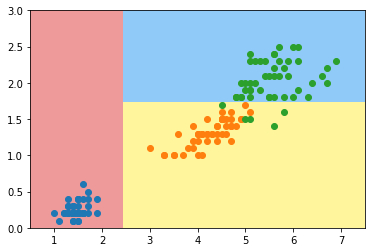

In [8]:
plot_decision_boundary(dt, axis=[0.5, 7.5, 0, 3])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])
plt.scatter(X[y==2, 0], X[y==2, 1])

## 信息熵

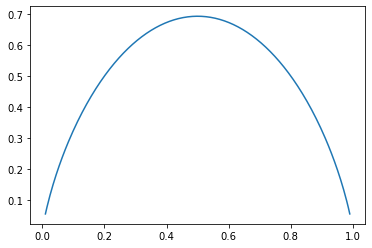

In [9]:
def entropy(p):
    return -p * np.log(p) - (1 - p) * np.log(1 - p)

# 构建不同的比例，这里避免log(0)的计算，所以要避免p=0和1-p=0
x = np.linspace(0.01, 0.99, 200)

# 将不同比例和不同信息熵的值绘制出来
plt.plot(x, entropy(x))
plt.show()

## 使用信息熵寻找最优化分

In [10]:
# 四个参数分别为样本特征数据、样本目标数据、维度、阈值
# 划分后左侧和右侧的索引数组
def split(X, y, d, v):
    index_l = (X[:, d] <= v)
    index_r = (X[:, d] > v)
    return X[index_l], X[index_r], y[index_l], y[index_r]

In [11]:
# 构建一个五行四列的样本数据
X = np.linspace(1, 10, 20)
X = X.reshape(5, 4)
y = 2 * X + 3

In [12]:
# 期望以第1个维度，既第1列特征为划分维度，以5为划分阈值
X_l, X_r, y_l, y_r = split(X, y, 1, 5)

X_l

array([[1.        , 1.47368421, 1.94736842, 2.42105263],
       [2.89473684, 3.36842105, 3.84210526, 4.31578947]])

In [13]:
# 如果以第0个维度，既第0列特征为划分维度，以5为划分阈值，那么X_l为三行四列矩阵，因为第0列的第三行值也小于5
X_l, X_r, y_l, y_r = split(X, y, 0, 5)

X_l

array([[1.        , 1.47368421, 1.94736842, 2.42105263],
       [2.89473684, 3.36842105, 3.84210526, 4.31578947],
       [4.78947368, 5.26315789, 5.73684211, 6.21052632]])

In [14]:
from collections import Counter
from math import log
# 计算信息熵时不关心样本特征，只关心样本目标数据的类别和每个类别的数量
def entropy(y):
    # 使用Counter生成字典，key为y的值，value为等于该值的元素数量
    counter_y = Counter(y)
    entropy_result = 0
    for num in counter_y.values():
        p = num / len(y)
        # 将所有类别的占比加起来，得到信息熵
        entropy_result += -p * log(p)
        
    return entropy_result

In [15]:
test_y = np.array([0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3])
test_y1 = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# test_y信息熵应该比较大，因为有4种类别
entropy(test_y)

1.3421257227487469

In [16]:
# test_y1信息熵应该比较小，因为有2种类别
entropy(test_y1)

0.5982695885852573

In [17]:
# 寻找最优信息熵
def try_split(X, y):
    
    # 最优信息熵初始取无穷大
    best_entropy = float('inf')
    # 最优维度和最优阈值，初始值为-1
    best_d, best_v = -1, -1
    
    # 对样本特征数据的每个维度，既每个特征进行搜索
    for d in range(X.shape[1]):
        # 在d这个维度上，将每两个样本点中间的值作为阈值
        # 对样本数据在d这个维度上进行排序，返回排序索引
        sorted_index = np.argsort(X[:, d])
        # 遍历每行样本数据，注意从第一行开始，因为需要用上一行的值和该行的值求均值
        for row in range(1, len(X)):
            # 如果两个值相等，那么均值无法区分这两个值，所以忽略这种情况
            if X[sorted_index[row-1], d] != X[sorted_index[row], d]:
                v = (X[sorted_index[row-1], d] + X[sorted_index[row], d]) / 2
                # 使用split()函数做划分
                X_l, X_r, y_l, y_r = split(X, y, d, v)
                # 求划分后两部分的信息熵
                e = entropy(y_l) + entropy(y_r)
                # 保存最优信息熵、维度、阈值
                if e < best_entropy:
                    best_entropy, best_d, best_v = e, d, v
                    
    return best_entropy, best_d, best_v

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, 2:]
y = iris.target

best_entropy, best_d, best_v = try_split(X, y)
print("best_entropy = ", best_entropy)
print("best_d = ", best_d)
print("best_v = ", best_v)

In [ ]:
X_l1, X_r1, y_l1, y_r1 = split(X, y, best_d, best_v)
entropy(y_l1)

In [ ]:
best_entropy2, best_d2, best_v2 = try_split(X_r1, y_r1)
print("best_entropy2 = ", best_entropy2)
print("best_d2 = ", best_d2)
print("best_v2 = ", best_v2)

In [ ]:
X_l2, X_r2, y_l2, y_r2 = split(X_r1, y_r1, best_d2, best_v2)
entropy(y_l2)

## 基尼系数

In [ ]:
from sklearn import datasets

# 构建样本数据
X, y = datasets.make_moons(noise=0.25, random_state=666)

# 绘制样本数据
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])

In [ ]:
# 不传入任何参数，既criterion默认使用gini，决策树深度划分到不能划分为止
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X, y)

In [ ]:
# 绘制决策边界
plot_decision_boundary(dt_clf, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])

In [ ]:
# 限定决策树深度为2
dt_clf2 = DecisionTreeClassifier(max_depth=2)
dt_clf2.fit(X, y)

# 绘制决策边界
plot_decision_boundary(dt_clf2, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])

In [ ]:
# 每个节点至少有10个数据时才会继续拆分下去
dt_clf3 = DecisionTreeClassifier(min_samples_split=10)
dt_clf3.fit(X, y)

# 绘制决策边界
plot_decision_boundary(dt_clf3, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])

In [ ]:
# 每个叶子节点至少要有6个样本数据
dt_clf4 = DecisionTreeClassifier(min_samples_leaf=6)
dt_clf4.fit(X, y)

# 绘制决策边界
plot_decision_boundary(dt_clf4, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])

In [ ]:
# 决策树的最大叶子节点个数为4
dt_clf5 = DecisionTreeClassifier(max_leaf_nodes=4)
dt_clf5.fit(X, y)

# 绘制决策边界
plot_decision_boundary(dt_clf5, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])

## CART

In [ ]:
# 使用波士顿房价数据
boston = datasets.load_boston()
X = boston.data
y = boston.target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train)

dt_reg.score(X_test, y_test)

In [ ]:
# 还是使用鸢尾花数据
iris = datasets.load_iris()
X = iris.data[:, 2:]
y = iris.target

from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(max_depth=2, criterion="entropy")
dt_clf.fit(X, y)

plot_decision_boundary(dt_clf, axis=[0.5, 7.5, 0, 3])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])
plt.scatter(X[y==2, 0], X[y==2, 1])

In [ ]:
# 删除样本数据中索引为138的数据
X_new = np.delete(X, 138, axis=0)
y_new = np.delete(y, 138)

dt_clf2 = DecisionTreeClassifier(max_depth=2, criterion="entropy")
dt_clf2.fit(X_new, y_new)

plot_decision_boundary(dt_clf2, axis=[0.5, 7.5, 0, 3])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])
plt.scatter(X[y==2, 0], X[y==2, 1])

best_entropy =  0.6931471805599453
best_d =  0
best_v =  2.45


In [22]:
X_l1, X_r1, y_l1, y_r1 = split(X, y, best_d, best_v)
entropy(y_l1)

0.0

In [23]:
best_entropy2, best_d2, best_v2 = try_split(X_r1, y_r1)
print("best_entropy2 = ", best_entropy2)
print("best_d2 = ", best_d2)
print("best_v2 = ", best_v2)

best_entropy2 =  0.4132278899361904
best_d2 =  1
best_v2 =  1.75


In [24]:
X_l2, X_r2, y_l2, y_r2 = split(X_r1, y_r1, best_d2, best_v2)
entropy(y_l2)

0.30849545083110386

## 基尼系数

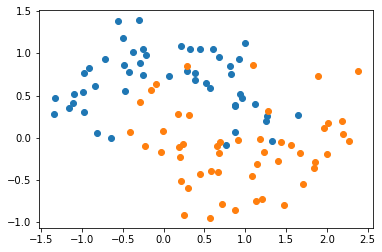

In [25]:
from sklearn import datasets

# 构建样本数据
X, y = datasets.make_moons(noise=0.25, random_state=666)

# 绘制样本数据
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])

In [26]:
# 不传入任何参数，既criterion默认使用gini，决策树深度划分到不能划分为止
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

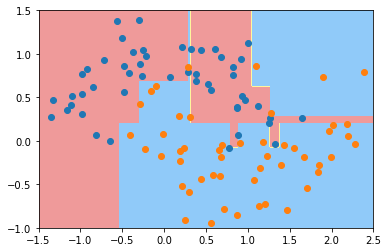

In [27]:
# 绘制决策边界
plot_decision_boundary(dt_clf, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])

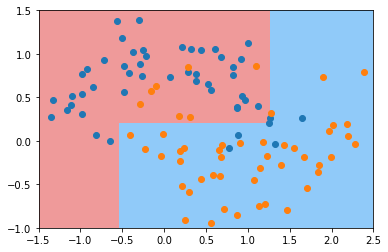

In [28]:
# 限定决策树深度为2
dt_clf2 = DecisionTreeClassifier(max_depth=2)
dt_clf2.fit(X, y)

# 绘制决策边界
plot_decision_boundary(dt_clf2, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])

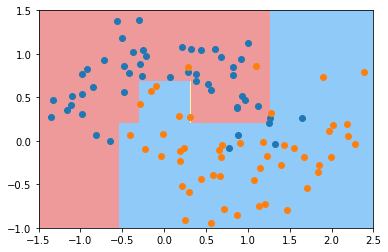

In [29]:
# 每个节点至少有10个数据时才会继续拆分下去
dt_clf3 = DecisionTreeClassifier(min_samples_split=10)
dt_clf3.fit(X, y)

# 绘制决策边界
plot_decision_boundary(dt_clf3, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])

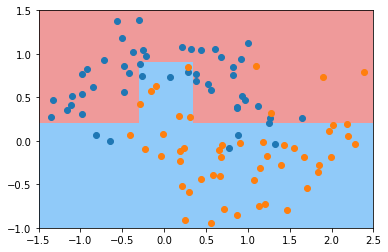

In [30]:
# 每个叶子节点至少要有6个样本数据
dt_clf4 = DecisionTreeClassifier(min_samples_leaf=6)
dt_clf4.fit(X, y)

# 绘制决策边界
plot_decision_boundary(dt_clf4, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])

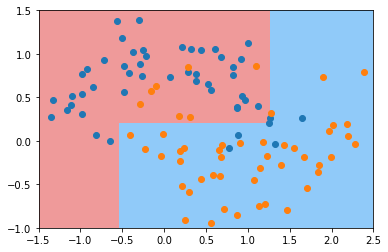

In [31]:
# 决策树的最大叶子节点个数为4
dt_clf5 = DecisionTreeClassifier(max_leaf_nodes=4)
dt_clf5.fit(X, y)

# 绘制决策边界
plot_decision_boundary(dt_clf5, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])

## CART

In [32]:
# 使用波士顿房价数据
boston = datasets.load_boston()
X = boston.data
y = boston.target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train)

dt_reg.score(X_test, y_test)

0.6076404085395047

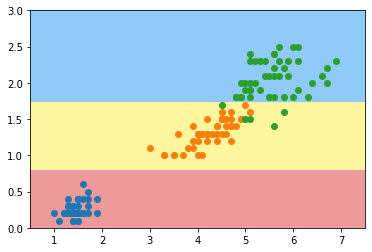

In [33]:
# 还是使用鸢尾花数据
iris = datasets.load_iris()
X = iris.data[:, 2:]
y = iris.target

from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(max_depth=2, criterion="entropy")
dt_clf.fit(X, y)

plot_decision_boundary(dt_clf, axis=[0.5, 7.5, 0, 3])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])
plt.scatter(X[y==2, 0], X[y==2, 1])

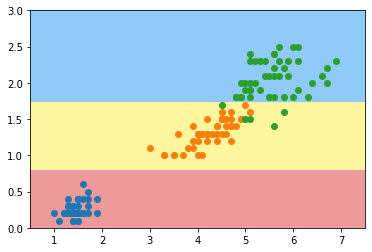

In [34]:
# 删除样本数据中索引为138的数据
X_new = np.delete(X, 138, axis=0)
y_new = np.delete(y, 138)

dt_clf2 = DecisionTreeClassifier(max_depth=2, criterion="entropy")
dt_clf2.fit(X_new, y_new)

plot_decision_boundary(dt_clf2, axis=[0.5, 7.5, 0, 3])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])
plt.scatter(X[y==2, 0], X[y==2, 1])